## Run MCMC inference using GP model

In [42]:
import random
import time

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import pickle

import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.priors import Matern52, SquaredExponential
from experiments.zimbabwe.zimbabwe_utility import read_data

In [2]:
data_path = "../data/zwe2016phia.geojson"
num_warmup = 2000
num_samples = 10000
num_chains = 2

## Load Data

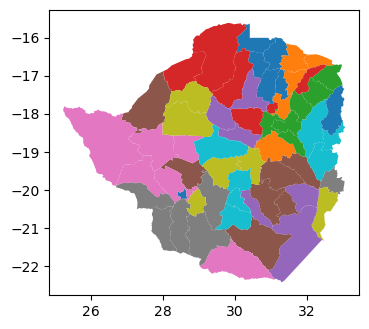

In [3]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

In [4]:
x, data_centroid = read_data(data_path, normalize=False)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


In [5]:
## Adding estimate data
data_centroid["estimate"] = data["estimate"]

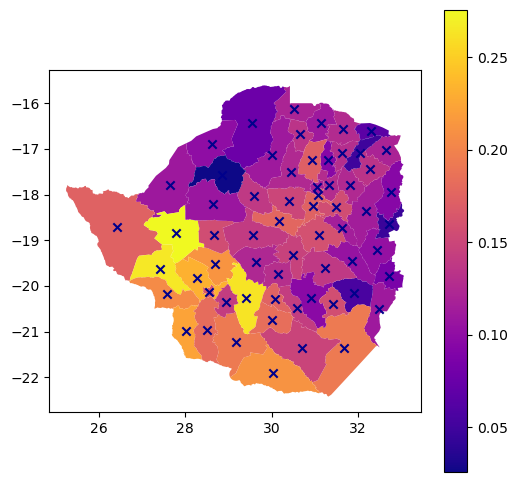

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

In [7]:
def model_centroids(x, n_obs=None, kernel=Matern52(), y=None):
    
    # fixed effects
    b0 = numpyro.sample('b0', npdist.Normal(0, 1))
     
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2,4)) 
    kernel.lengthscale = lengthscale
    k = kernel(x, x)
    
    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # linear predictor
    lp = b0 + re
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

## Observations

In [8]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## GP Prior

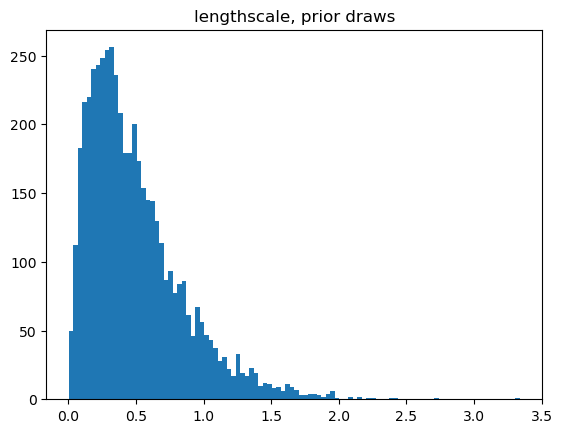

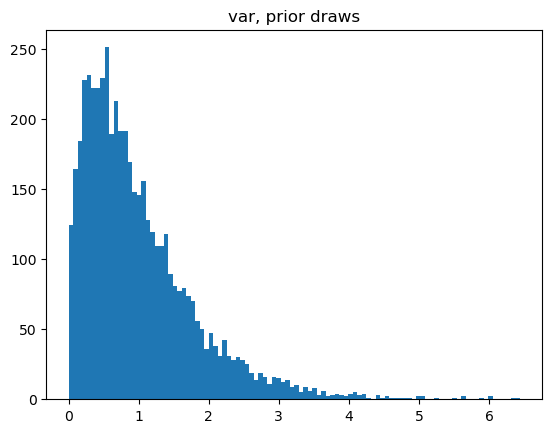

In [9]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_centroids, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['variance']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

## MCMC Inference using GP Prior

In [10]:
fname = 'zimbabwe_gp_mcmc.pkl'

rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
kernel = NUTS(model_centroids)
mcmc_gp = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_gp.run(rng_key, x=x, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
t_elapsed = time.time() - start

/var/folders/bh/pyjj9wbj1qn8sh8qnz_jdwzw0000gp/T/ipykernel_43814/1277924111.py:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_gp = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [01:57<00:00, 101.82it/s, 63 steps of size 7.15e-02. acc. prob=0.85]


In [11]:
with open(fname, 'wb') as f:
    pickle.dump(mcmc_gp, f)

In [12]:
mcmc_gp.print_summary(exclude_deterministic=False)
mcmc_gp_samples = mcmc_gp.get_samples()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           b0     -1.79      0.15     -1.79     -2.04     -1.56    288.31      1.00
  lengthscale      1.09      0.25      1.07      0.72      1.54    311.69      1.01
        re[0]      0.22      0.16      0.22     -0.06      0.48    376.84      1.00
        re[1]     -0.03      0.16     -0.03     -0.28      0.25    319.70      1.01
        re[2]     -0.09      0.16     -0.09     -0.34      0.19    336.15      1.00
        re[3]     -0.31      0.20     -0.31     -0.64      0.00    522.37      1.00
        re[4]     -0.46      0.22     -0.46     -0.83     -0.10    889.61      1.00
        re[5]     -0.27      0.20     -0.27     -0.60      0.05    518.47      1.00
        re[6]     -0.27      0.19     -0.27     -0.59      0.03    430.46      1.00
        re[7]     -0.44      0.19     -0.44     -0.75     -0.12    518.39      1.00
        re[8]     -0.50      0.22     -0.50     -0.88     -0.15    902.33  

In [13]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 204 s
Average ESS for all REs : 483


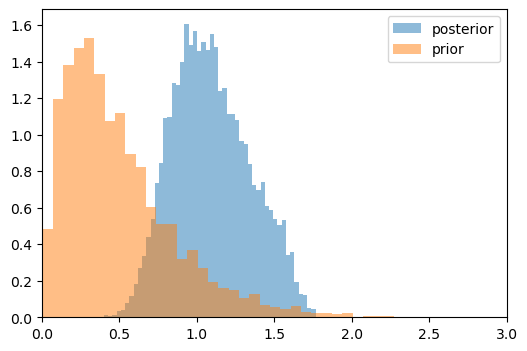

In [43]:
c_samps_gp = mcmc_gp_samples['lengthscale']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
plt.xlim([0, 3])

tikzplotlib.save(r"lengthscale.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

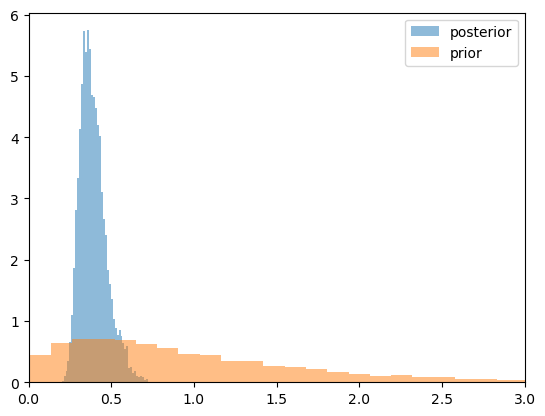

In [44]:
var_samps_gp = mcmc_gp_samples['variance']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

tikzplotlib.save(r"variance.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

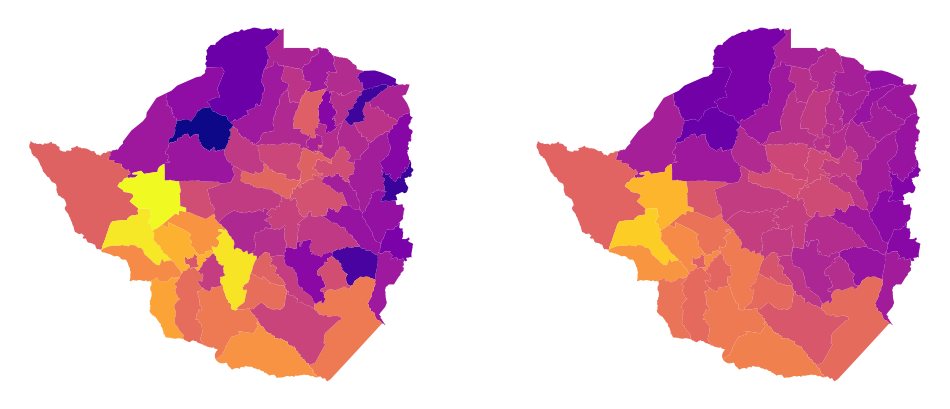

In [25]:
# posterior predictive
posterior_predictive = Predictive(model_centroids, mcmc_gp_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         x=x, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_gp = posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

data['theta_gp'] = theta_mean_gp

theta_observed = jnp.array(data['estimate'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")

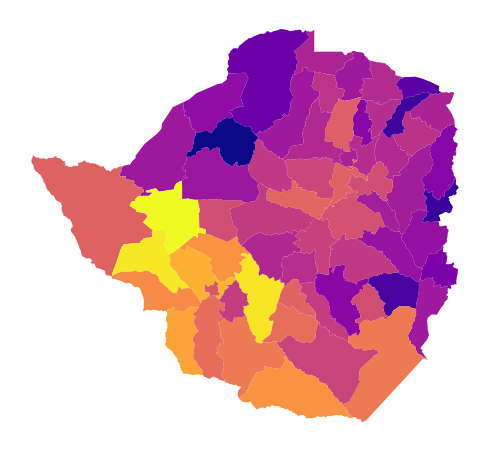

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")
plt.tight_layout()
plt.savefig("estimate.pdf")
plt.show()

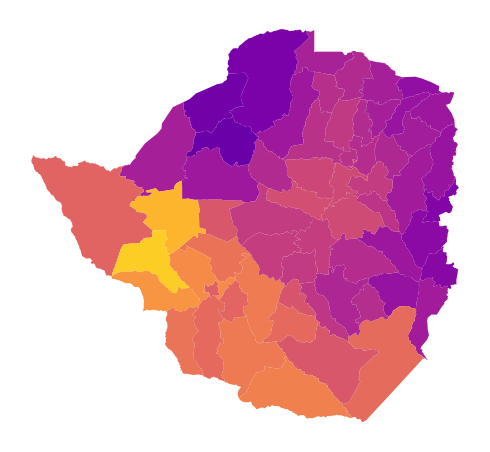

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="theta_gp", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")
plt.tight_layout()
plt.savefig("gp_inference.pdf")
plt.show()